# Experiment Data Conversion

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil 
import json

from skimage import draw
from itertools import combinations
from dataclasses import dataclass
from PIL import Image, ImageOps
from pathlib import Path
from typing import Any, List
from tqdm import tqdm

ModuleNotFoundError: No module named 'cv2'

In [2]:
# These are local files in the repository
from telfer_video_io import get_fname, VideoWriter, VideoReader
from telfer_transforms import transform_array_to_perspective, transform_dataframe_to_perspective, get_homography

## Data Folders

In [3]:
PROJECT_DIR = Path("/home/andretelfer/shared/curated/fran/v4/")

assert PROJECT_DIR.exists()

In [4]:
datafiles = pd.read_csv(PROJECT_DIR / 'datafiles.csv')

items = []
for video in datafiles.video:
    fname = Path(video).parts[-1].split('.')[0]
    dlc_file = next(PROJECT_DIR.glob(f"mouse_labels/{fname}DLC*.h5"))
    items.append({'Video': video, 'Keypoints': '/'.join(dlc_file.parts[-2:])})
    
datafiles = pd.DataFrame(items)
datafiles

,Video,Keypoints
0,videos/f1.mp4,mouse_labels/f1DLC_resnet50_agrpNov19shuffle1_...
1,videos/f2.mp4,mouse_labels/f2DLC_resnet50_agrpNov19shuffle1_...
2,videos/f3.mp4,mouse_labels/f3DLC_resnet50_agrpNov19shuffle1_...
3,videos/f4.mp4,mouse_labels/f4DLC_resnet50_agrpNov19shuffle1_...
4,videos/f5.mp4,mouse_labels/f5DLC_resnet50_agrpNov19shuffle1_...
...,...,...
75,videos/m28.mp4,mouse_labels/m28DLC_resnet50_agrpNov19shuffle1...
76,videos/m29.mp4,mouse_labels/m29DLC_resnet50_agrpNov19shuffle1...
77,videos/m30.mp4,mouse_labels/m30DLC_resnet50_agrpNov19shuffle1...
78,videos/m31.mp4,mouse_labels/m31DLC_resnet50_agrpNov19shuffle1...


In [62]:
treatments = pd.read_csv(PROJECT_DIR / 'experiment-data.csv')
treatments.injected_with = treatments.injected_with.str.replace('/', '-')
treatments

,id,latency_to_approach,time_in_corners,time_eating,amount_eaten,does_not_leave_corner,does_not_approach,injected_with
0,f1,15.00,136.99,9.84,0.3,False,False,saline-ghrelin
1,f2,36.43,122.55,0.00,0.0,False,False,saline-saline
2,f3,17.38,32.54,1.12,0.0,False,False,mt2-saline
3,f4,27.95,129.35,2.58,0.1,False,False,mt2-ghrelin
4,f5,9.88,201.56,2.73,0.0,False,False,saline-saline
...,...,...,...,...,...,...,...,...
75,m28,123.63,509.66,0.00,0.0,False,False,mt2-ghrelin
76,m29,16.22,343.84,17.49,0.1,False,False,saline-saline
77,m30,18.42,319.65,7.28,0.1,False,False,saline-ghrelin
78,m31,540.00,443.65,0.00,0.0,False,False,mt2-saline


In [5]:
registration_points = pd.read_csv(PROJECT_DIR / "registrations.csv")
registration_points['video'] = registration_points['axis-0'].apply(lambda x: datafiles.Video.iloc[x])
registration_points = registration_points.rename(columns={'axis-1': 'x', 'axis-2': 'y'})
registration_points.sample(3)

,index,shape-type,vertex-index,axis-0,x,y,video
31,7,polygon,3,7,474.043305,237.664651,videos/f8.mp4
33,8,polygon,1,8,149.671753,667.907474,videos/f9.mp4
252,64,polygon,0,63,72.333165,252.681853,videos/m16.mp4


## Registration

Define the schema of the box in mm

In [6]:
w, h = 500, 400
p = padding = 0
OUTPUT_WIDTH = w #+ padding*2
OUTPUT_HEIGHT = h #+ padding*2

REGISTRATION_POINTS = np.array([
    [0+p, 0+p],
    [w+p, 0+p],
    [w+p, h+p],
    [0+p, h+p],
])
REGISTRATION_POINTS

array([[  0,   0],
       [500,   0],
       [500, 400],
       [  0, 400]])

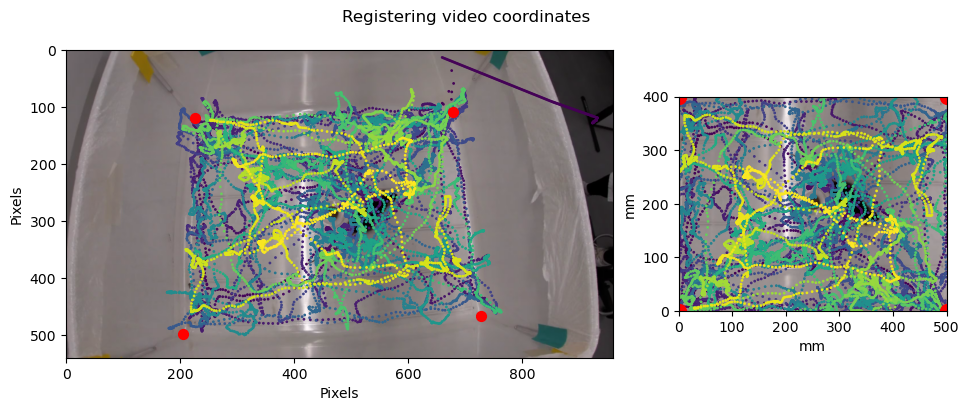

In [7]:
for video, points in registration_points.groupby("video"):
    points = points[["y", "x"]].values
    T = get_homography(points, REGISTRATION_POINTS)
    
    row = datafiles.loc[datafiles.Video == video].iloc[0]
    keypoints = pd.read_hdf(PROJECT_DIR / row.Keypoints)
    keypoints = keypoints.where(keypoints.xs("likelihood", level="coords", axis=1) > 0.6)
    keypoints = keypoints.interpolate()
    
    centroid = keypoints.groupby(axis=1, level="coords").mean()
    reader = VideoReader(PROJECT_DIR / video)
    frame = reader[1000]
    
    plt.figure(figsize=(12, 4))
    gs = plt.GridSpec(1, 10)
    plt.subplot(gs[:7])
    plt.imshow(frame)
    c = np.arange(centroid.shape[0])
    plt.scatter(centroid.x, centroid.y, c=c, s=1)
    
    y, x = points.T
    plt.scatter(y, x, color='red', s=50)
    
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    
    plt.subplot(gs[7:])
    plt.imshow(cv2.warpPerspective(frame, T, (w,h)))
    plt.xlabel("mm")
    plt.ylabel("mm")
    
    keypoints = transform_dataframe_to_perspective(keypoints, T)
    centroid = keypoints.groupby(axis=1, level="coords").mean()
    c = np.arange(centroid.shape[0])
    plt.scatter(centroid.x, centroid.y, c=c, s=1)
    plt.xlim([0, w])
    plt.ylim([0, h]) 
    
    y, x = REGISTRATION_POINTS.T
    plt.scatter(y, x, color='red', s=100)
    
    plt.suptitle("Registering video coordinates")
    plt.show()
    break

## Coordinates to grid

Text(0, 0.5, 'mm')

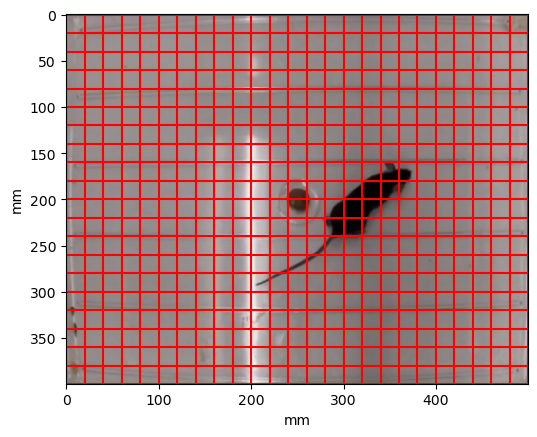

In [8]:
grid_square_size = 20 # in mm

vlines = np.arange(0, w+grid_square_size/2, grid_square_size)
hlines = np.arange(0, h+grid_square_size/2, grid_square_size)

plt.vlines(vlines, 0, h, colors='red')
plt.hlines(hlines, 0, w, colors='red')

plt.imshow(cv2.warpPerspective(frame, T, (w,h)))
plt.xlabel("mm")
plt.ylabel("mm")

In [69]:
def create_path_between_points(x0, y0, x1, y1):
        dirx = 1 if x1 - x0 > 0 else -1 
        diry = 1 if y1 - y0 > 0 else -1
        path = []
        xi = x0
        yi = y0
        while not (xi == x1 and yi == y1):
            path.append((xi, yi))
            if xi != x1:
                xi += dirx
            elif yi != y1:
                yi += diry

        return path
    
def coordinates_to_path(centroid, grid_square_size, w, h):
    x = (centroid.x // grid_square_size).astype(int)
    y = (centroid.y // grid_square_size).astype(int)

    # Clip around bounds
    xmin = 0
    xmax = int(w // grid_square_size) - 1
    ymin = 0
    ymax = int(h // grid_square_size) - 1
    x = np.clip(x, xmin, xmax)
    y = np.clip(y, ymin, ymax)

    # Create the path
    path = []
    path_frame = []
    xlast = None 
    ylast = None 
    p0 = None # Starting position
    for i in range(1, len(x)):
        # Skip until the first element
        if xlast is None or ylast is None:
            if i in x.index and i in y.index:
                xlast = x[i]
                ylast = y[i]

            continue

        dx = x[i] - xlast
        dy = y[i] - ylast        
        # If elements are not neighbors, add an artificial path
        if abs(dx) + abs(dy) > 1:
            subpath = create_path_between_points(xlast, ylast, x[i], y[i])
            path += subpath
            path_frame += [i]*len(subpath)
        else:
            path.append((xlast, ylast))
            path_frame.append(i)

        xlast, ylast = x[i], y[i]
        
    # Validate
    path_x, path_y = zip(*path)
    for i in range(len(path_x)-1):
        dx = path_x[i+1] - path_x[i]
        dy = path_y[i+1] - path_y[i]
        assert abs(dx) + abs(dy) <= 1
    
    return path, path_frame

path, path_frame = coordinates_to_path(centroid, grid_square_size, w, h)

In [68]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

fig = plt.figure()
ax = plt.axes()
im = ax.imshow(cv2.warpPerspective(frame, T, (w,h)))
ax.hlines(hlines, 0, w)
ax.vlines(vlines, 0, h)
ax.set_xlim(0, max(vlines))
ax.set_ylim(0, max(hlines))

path, path_frame = coordinates_to_path(centroid, grid_square_size, w, h)

def animate(i):
    i = 1000 + i
    frame_index = path_frame[i]
    frame = reader[frame_index]
    im.set_data(cv2.warpPerspective(frame, T, (w,h)))
    
    x, y = path[i]
    grid = ax.add_patch(
        plt.Rectangle([x*grid_square_size, y*grid_square_size], grid_square_size, grid_square_size))
    
    return im,

    # line.set_data(x, y)
    # return line,

anim = FuncAnimation(fig, animate, frames=200, interval=20, blit=True)
anim.save('demo.gif', writer='imagemagick')
plt.cla()
plt.close()

MovieWriter imagemagick unavailable; using Pillow instead.


<img src="./demo.gif"/>

## Coordinates to actions

In [70]:
def path_to_actions(path):
    path = np.array(path)
    actions = []
    for i in range(len(path)-1):
        dx, dy = path[i+1] - path[i]

        # Actions are defined in the environment
        if dy == -1:
            action = 0
        elif dx == 1:
            action = 1
        elif dy == 1:
            action = 2
        elif dx == -1:
            action = 3
        else:
            action = 4
    
        actions.append(action)
    
    # validate
    xi, yi = path[0]
    for i, action in enumerate(actions):
        if action == 0:
            yi -= 1
        elif action == 1:
            xi += 1
        elif action == 2:
            yi += 1
        elif action == 3:
            xi -= 1
        else:
            pass
        
        assert (xi == path[i+1,0]) and (yi == path[i+1,1])
        
    return path[0], actions

s0, actions = path_to_actions(path)

## Final 

In [99]:
xmin = 0
xmax = int(w // grid_square_size) - 1
ymin = 0
ymax = int(h // grid_square_size) - 1
xmax, ymax  

(24, 19)

In [93]:
output_directory = Path("mouse_rl_dataset0")
if output_directory.exists() and input("clear existing directory? (y/n)") == 'y':
    ! rm -rf {output_directory}
    
output_directory.mkdir(parents=True)
    
for video, points in tqdm(registration_points.groupby("video")):
    # Load and transform data 
    points = points[["y", "x"]].values
    T = get_homography(points, REGISTRATION_POINTS)
    
    row = datafiles.loc[datafiles.Video == video].iloc[0]
    keypoints = pd.read_hdf(PROJECT_DIR / row.Keypoints)
    keypoints = keypoints.where(keypoints.xs("likelihood", level="coords", axis=1) > 0.6)
    keypoints = keypoints.interpolate()    
    centroid = keypoints.groupby(axis=1, level="coords").mean()
    
    keypoints = transform_dataframe_to_perspective(keypoints, T)
    centroid = keypoints.groupby(axis=1, level="coords").mean()
    
    # Create path from centroid position
    path, path_frame = coordinates_to_path(centroid, grid_square_size, w, h)
    
    # Path to actions 
    s0, actions = path_to_actions(path)
    
    # Get treatment information
    id = Path(video).parts[-1].split('.')[0]
    treatment = treatments.loc[treatments.id == id].iloc[0].injected_with
    
    # Saving
    output_file = output_directory / treatment / f"{id}.json"
    if not output_file.parent.exists():
        output_file.parent.mkdir(parents=True)
        
    with open(output_file, 'w') as fp:
        json.dump({
            "initial_position": np.array(path[0]).astype(int).tolist(),
            "actions": actions,
            "path": np.array(path).astype(int).tolist(),
            "corresponding_frames": path_frame,
            "id": id,
            "treatment": treatment
        }, fp, indent=4)

clear existing directory? (y/n) y


100%|████████████████████████████████████████████████████████| 80/80 [00:19<00:00,  4.11it/s]
